# Malicious URL Detection With Machine Learning om Amazon SageMaker

This workshop is based on a article on Medium https://medium.com/@ismaelbouarfa/malicious-url-detection-with-machine-learning-d57890443dec <br/>
The purpose of this workshop is to classify URLs given as inputs to predict if they are dangerous or inoffensive.
We selected **good** as a label for the legitimate ones and **bad** for the malicious. Using a dataset with many URLs (as text) already labeled, located in a CSV file, we’ll train our model.

## Anatomy of a URL<br>

![](https://miro.medium.com/max/1050/0*EaleKgM4uK8sCpvy)<br>


We will start by following the original post by using SKLearn and NumPy

Please replace **ENTER YOUR BUCKET NAME HERE** with your bucket name that you created earlier

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

bucket = "ENTER YOUR BUCKET NAME HERE"

Now we copy over our datasets from a public S3 bucket. The GIT Repo for this dataset has been commented out and provided for your information <br>
Also an additional dataset called gdms_data.csv is present and contains additional urls and their statuses to augment the dataset

In [2]:
# Original Source dataset 
#! git clone https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs.git
! aws s3 cp s3://ml-materials/malicious-url-dataset/data.csv .
! aws s3 cp s3://ml-materials/malicious-url-dataset/gdms_data.csv .

download: s3://ml-materials/malicious-url-dataset/data.csv to ./data.csv
download: s3://ml-materials/malicious-url-dataset/gdms_data.csv to ./gdms_data.csv


Here we load the datasets into dataframes, sanitize the datasets and then create a new column that maps the "good" and "bad" classes to 0 and 1<br>
The source dataset contains 60K urls and statuses 

## Step 1: Data exploration and sanitization

In [3]:
# Load the datasets into dataframes
df = pd.read_csv('./data.csv',',',error_bad_lines=False)
df = pd.DataFrame(df)
df2 = pd.read_csv('./gdms_data.csv',',',error_bad_lines=False)
df2 = pd.DataFrame(df2)

# Create a random sample set of 10000 rows
df = df.sample(n=10000)

# Append the custom dataset to the training dataset
df = df.append(df2)

from io import StringIO
col = ['label','url']
df = df[col]

#Deleting nulls
df = df[pd.notnull(df['url'])]

#more settings for our data manipulation
df.columns = ['label', 'url']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

So now lets take a look at our resulting dataset

In [4]:
df

,label,url,category_id
355922,good,trueknowledge.com/q/facts_about__saint-raymond...,0
63413,good,cnd-m.org/en/news/2010070801.php,0
52550,good,beermadehere.blogspot.com/,0
411829,bad,bumitorsen.ru/sliva/gate.php,1
128314,good,oralhistory.rutgers.edu/Interviews/indexes/med...,0
...,...,...,...
308411,good,newzealand.com/travel/media/press-releases/201...,0
415955,bad,viviendadelrincon.com/f7yes1g27p,1
100369,good,heavymetal.about.com/b/2008/05/22/guitarist-mi...,0
0,bad,gmail.com,1


As we can see, we have a dataset composed of good and bad urls. Now, how can we detect if we have more good urls in the dataset? <br>This code allows you to create a simple bar chart of class proportion.

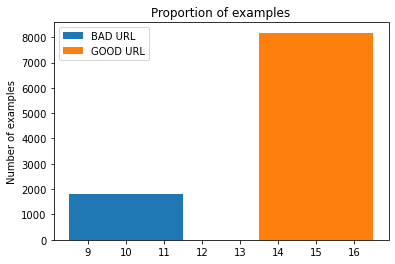

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
BAD_len = df[df['label'] == 'bad'].shape[0]
GOOD_len = df[df['label'] == 'good'].shape[0]
plt.bar(10,BAD_len,3, label="BAD URL")
plt.bar(15,GOOD_len,3, label="GOOD URL")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

We have more good URLs. That’s what we thought. We can learn more from the good URLs to avoid bias or generalize words present in bad URL and false positives then.

## Step 2: Model Selection and applying Natural language processing
Now that we have our dataset we’ll choose an approach:<br><br>
What is NLP? It is the science of programming computers to process and analyze natural language. Some large and mature applications are speech recognition, translation, text classification, and so on. As the URLs are full of words (domaine name, path, file, extension…) we wanted to try it!<br><br>
As learning algorithms work with numerical features we need to convert words into numerical vectors. How does it works? The first entry technique is called “Bag Of Words”.<br><br>
In Bag of Words a good classifier detects patterns in words distribution and which words occur and how many times for each kind of text. However, words count is not always the best idea. As demonstrated previously, a URL can be very large and add bias for our predictions.
The following code allows you to represent for each different length the number of URLs.

<AxesSubplot:>

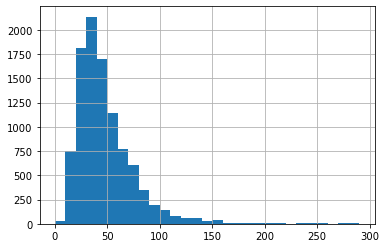

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
lens = df.url.str.len()
lens.hist(bins = np.arange(0,300,10))

So here we are going to define a function to tokenize the URL strings so we can generate feature vectors.<br>
Note this function also removes common urls comntaining **.com** as it would be too prevalent and might skew the predictions from our model<br>
Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics. The process of converting words into numbers are called Vectorization.

In [7]:
#tokenizer function for URL by Faizan Ahmad, CEO FSecurify
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

We choose to avoid Bags of Words and use another technique. So improving our model can be done using Term Frequency (TF) and Inverse Document Frequency (IDF):<br>
![](https://miro.medium.com/max/1050/1*V01pYGwqnMlWiwP26NjbZQ.png)<br>
This technique downscales the influence of some respecting words:

In [8]:
#y = [d[1]for d in df] #labels
#myUrls = [d[0]for d in df] #urls
vectorizer = TfidfVectorizer( tokenizer=getTokens ,use_idf=True, smooth_idf=True, sublinear_tf=False)
features = vectorizer.fit_transform(df.url).toarray().astype('float32')
labels = df.label
features.shape

(10002, 24416)

In [9]:
type(features)

numpy.ndarray

In [10]:
df

,label,url,category_id
355922,good,trueknowledge.com/q/facts_about__saint-raymond...,0
63413,good,cnd-m.org/en/news/2010070801.php,0
52550,good,beermadehere.blogspot.com/,0
411829,bad,bumitorsen.ru/sliva/gate.php,1
128314,good,oralhistory.rutgers.edu/Interviews/indexes/med...,0
...,...,...,...
308411,good,newzealand.com/travel/media/press-releases/201...,0
415955,bad,viviendadelrincon.com/f7yes1g27p,1
100369,good,heavymetal.about.com/b/2008/05/22/guitarist-mi...,0
0,bad,gmail.com,1


## Step 3: Model Training
Logistic regression is used to model the probability of a certain class. Nowadays it is used in various fields, predicting risks of developing a disease based on test results, to classify if an image contains a rose or a cactus.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
clf = LogisticRegression(random_state=0) 
clf.fit(X_train,y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

train accuracy = 0.8768903887014123
test accuracy = 0.8520739630184908


In the code above, we divided our dataset in a train test used to fit the parameters and feed our model. Then with the test set we validated our model with an unbiased evaluation. The scores are good:<br><br>
train accuracy = 0.843375<br><br>
Based on the real class of the labels and the predicted class, we can introduce the following concepts: Type I error & Type II error (from the confusion matrix). As you can imagine, when classifying images on one category or another, it’s possible to have two types of errors:<br><br>
The type I error occurs when something is true but rejected, also known as false positive or false alarm.<br>
The type II error occurs when something is false but accepted, it’s a false negative.

Text(0.5, 15.0, 'Predicted')

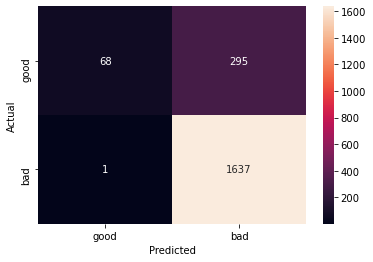

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
 xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

As shown, approx 16K bad URL have been correctly predicted as malicious URLs. However approx 300 legitimate URLs have been identified as malicious. These “false alarms” are known as Type I error. This kind of errors are one example of reason why monitoring and supervision are necessary when applying machine learning to cybersecurity.

## Step 4: Predictions
And then we made our predictions:

In [13]:
X_predict = ['yahoo.fr','www.radsport-voggel.de/wp-admin/includes/log.exe','hello.ru','auction-korea.co.kr/technote7/peace/','https://www.kdnuggets.com/2016/10/machine-learning-detect-malicious-urls.html','https://mail.google.com/','https://gmail.com']
X_feature_vectors = vectorizer.transform(X_predict)
y_Predict = clf.predict(X_feature_vectors)
print(y_Predict)

['good' 'bad' 'good' 'good' 'good' 'good' 'good']


# Performing Steps 2 through 4 in Amazon SageMaker

Technically we do not really need to do the next two cells as we already did it earlier. These have been left in to show a more complete example in SageMaker

So here we use the TfidfVectorizer to create the feature vectors for the URL's  

In [14]:
vectorizer = TfidfVectorizer( tokenizer=getTokens ,use_idf=True, smooth_idf=True, sublinear_tf=False)
labels = df.label

In [15]:
dnsfeat = vectorizer.fit_transform(df.url).toarray().astype('float32')
gen_labels = labels.replace({'good': 0, 'bad': 1}).values.astype('float32')
dnsfeat.shape

(10002, 24416)

For the variable gen_labels you can see its very similar to the category_id that we calculated earlier. We leave it as an exercise to replace gen_labels with category_id from the dataframe 

In [16]:
type(df.category_id)

pandas.core.series.Series

In [17]:
dnsfeat.shape

(10002, 24416)

Now we load the libraries for SageMaker and boto3 for the AWS Python SDK

In [18]:
import sagemaker
import io
import os
import boto3
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
role = get_execution_role()

Here we are creating the training file and storing it to your bucket in S3

In [19]:
sess = sagemaker.Session()
prefix = "sagemaker/mal-url"

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, dnsfeat, gen_labels)
buf.seek(0)

key = 'linearlearner'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://mybuck-1234-agm/sagemaker/mal-url/train/linearlearner
training artifacts will be uploaded to: s3://mybuck-1234-agm/sagemaker/mal-url/output


We are going to use LinearLearner (a SageMaker Built-in Algorithm) to be able to do a similar Logistic Regression that was used earlier. This algorithm requires the number of features which we calculate next  

In [20]:
num_features = len(dnsfeat[0])

Next we get the latest container available for the LinearLearner algorithm from our region

In [21]:
from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

Now we set up the hyperparameters for this algorithm, the output location for our model artifacts and start the training job. <br>
This cell takes approx 20 minutes to run<br>
NOTE other alternate values have been provided and commented out for you to test later 

In [22]:
%%time
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(predictor_type="binary_classifier",epochs=200,mini_batch_size=100,loss="logistic",optimizer="sgd") 
# Other Hyperparameters to try
# mini_batch_size=200
# mini_batch_size=1000
# remove optimizer="sgd"

linear.fit({"train": s3_train_data},logs=False)


2021-12-22 16:59:50 Starting - Starting the training job
2021-12-22 16:59:52 Starting - Launching requested ML instances...............
2021-12-22 17:01:14 Starting - Preparing the instances for training................
2021-12-22 17:02:38 Downloading - Downloading input data.....
2021-12-22 17:03:09 Training - Downloading the training image...........
2021-12-22 17:04:08 Training - Training image download completed. Training in progress.................................................................................................................................................................................................
2021-12-22 17:20:22 Uploading - Uploading generated training model.
2021-12-22 17:20:31 Completed - Training job completed
CPU times: user 1.21 s, sys: 101 ms, total: 1.31 s
Wall time: 20min 43s


Now the training job is finished, lets deploy this model to an endpoint to be able to perform real time predictions

In [23]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------!

Here we setup our endpoint serializers and deserializers. We are telling the endpoint to expect CSV format for input and output the. results as JSON

In [24]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

Lets do a single prediction from one of the rows in our training dataset

In [25]:
result = linear_predictor.predict(dnsfeat[30:31], initial_args={"ContentType": "text/csv"})
print(result)
print(gen_labels[30:31])
print(labels[30:31])

{'predictions': [{'score': 3.956290129281115e-06, 'predicted_label': 0}]}
[0.]
127757    good
Name: label, dtype: object


Let's now do some predictions on some new url's.<br>
Notice we take our test URL's and first convert it to a feature vector form and provide it to our endpoint to make the prediction.<br>

In [26]:
X_predict = ['yahoo.fr','www.radsport-voggel.de/wp-admin/includes/log.exe','hello.ru','auction-korea.co.kr/technote7/peace/','https://www.kdnuggets.com/2016/10/machine-learning-detect-malicious-urls.html','https://mail.google.com/','https://gmail.com']
X_feature_vectors = vectorizer.transform(X_predict).toarray()
result = linear_predictor.predict(X_feature_vectors, initial_args={"ContentType": "text/csv"})
for i in range(len(X_predict)):
    res = "good" if result['predictions'][i]['predicted_label']==0 else "bad"
    print(f'{X_predict[i]} - {res}')

yahoo.fr - good
www.radsport-voggel.de/wp-admin/includes/log.exe - bad
hello.ru - good
auction-korea.co.kr/technote7/peace/ - good
https://www.kdnuggets.com/2016/10/machine-learning-detect-malicious-urls.html - bad
https://mail.google.com/ - bad
https://gmail.com - bad


Before we delete our endpoint, lets see how this would in a practical application

So this prediction example works great in a notebook, however how would you use this vectorizer in your own scripts to call the endpoint when running outside of this notebook?

The answer is that we save the vectorizer model artifacts using the joblib format. In your prediction script/code you would then load the last generated vectorizer

First lets load the joblib library (joblib is a serialization library for models. An example of another library is pickle)

In [27]:
import joblib

Now lets save the vectorizer model to tfidf1.joblib. This could easily be uploaded to S3 although we are leaving on this notebook instance for this example

In [28]:
joblib.dump(vectorizer, open("tfidf1.joblib", "wb"))

Now lets load the vectorizer model and use it to create the feature vectors from our test URL's to send to our endpoint to make the predictions

In [29]:
new_vec = joblib.load('tfidf1.joblib')
New_X_test = ['yahoo.fr','www.radsport-voggel.de/wp-admin/includes/log.exe','hello.ru','auction-korea.co.kr/technote7/peace/','https://www.kdnuggets.com/2016/10/machine-learning-detect-malicious-urls.html']
New_X_test_vectorized = vectorizer.transform(New_X_test).toarray()
result = linear_predictor.predict(New_X_test_vectorized, initial_args={"ContentType": "text/csv"})
for i in range(len(New_X_test)):
    res = "good" if result['predictions'][i]['predicted_label']==0 else "bad"
    print(f'{X_predict[i]} - {res}')

yahoo.fr - good
www.radsport-voggel.de/wp-admin/includes/log.exe - bad
hello.ru - good
auction-korea.co.kr/technote7/peace/ - good
https://www.kdnuggets.com/2016/10/machine-learning-detect-malicious-urls.html - bad


Before we end this workshop, lets generate a confusion matrix of this model.

In [39]:
y_pred_list = []
new_y_pred = []
for i in range(0,len(X_test),50):
    tmpout=linear_predictor.predict(X_test[i:i+50], initial_args={"ContentType": "text/csv"})
    y_pred_list=y_pred_list + tmpout['predictions']
for vals in y_pred_list:
    new_y_pred.append(vals['predicted_label'])
y_pred = np.asarray(new_y_pred, dtype=np.float32)

In [41]:
y_test = y_test.replace({'good':0, 'bad':1}).values.astype('float32')

test accuracy = 0.9980009995002499


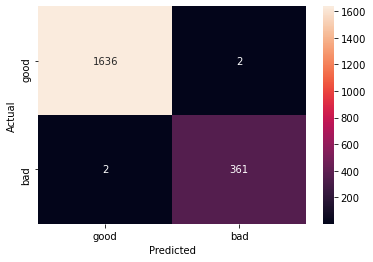

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
 xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
print ('test accuracy =', accuracy_score(y_test, y_pred))

Now lets go ahead and delete our endpoint 

In [ ]:
linear_predictor.delete_endpoint()